In [1]:
'''
IMPORTS
'''

%matplotlib inline

# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
import networkx as nx
import pandas
import collections
from collections import Iterable
from bisect import bisect
from networkx.algorithms.flow import edmonds_karp
from random import choice
import matplotlib.cm as cm

import seaborn; seaborn.set()

# Import widget methods
from IPython.html.widgets import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
class Ant(object):
    """
    Ant class, which encapsulates the entire behavior of an ant.
    """
    def __init__(self,model,ant_id,colony_id):
    
        # Set model link and ID
        self.model = model
        self.ant_id = (ant_id,colony_id)
        
    def random_walk(self,source,sink,alpha=1.0,beta=1.0,system=0):
        #Random Walk
        #initialize method
        self.alpha=alpha
        self.beta=beta
        self.source=source
        self.sink=sink
        self.system=system
        self.g=nx.DiGraph()
        
        #initialize needed global data for heuristic
        self.capacity_list=self.get_capacity_list(self.system)
        
        #initialize start of random walk
        self.last_nodes=self.source[:]
        
        #Create path for an ant
        terminate=0
        steps=0
        consecutive_no_additions=0
        while not terminate:
            #terminate=0
            new=0 #did this step add new nodes?
            for i in xrange(len(self.last_nodes)):
                '''
                Ant step is encompassed below
                '''
                steps+=1

                #track next nodes
                self.last_nodes_next=[]
                #print 'start of step',self.last_nodes
                #Check for sink inclusion
                sinks_included=1
                for sink_node in self.sink:
                    if sink_node not in self.g:
                        sinks_included=0  
                
                self.base_node=self.last_nodes[i]
                           
                if (self.base_node in self.sink) and sinks_included==1:
                    terminate_ant=self.make_decision(self.get_pheromone_termination(self.base_node,self.system))
                    #print 'do not terminate ant'
                    if terminate_ant==1: #0 is do not terminate
                        #print 'terminate ant:', (len(self.last_nodes)-1),'left'
                        continue
         
                #Get number of branches      
                self.branch_pheromone_list=self.get_pheromone_branch(self.base_node,self.system)
                #if self.g.out_degree(self.base_node)>0:
                    #self.branches=1
                #else:
                self.branches=self.make_decision(self.branch_pheromone_list)+1 #index of decision +1 is the number of branches chosen
                self.neighbors_chosen=[] #list other branches taken out of that node
                
                for branch in xrange(self.branches):
                    #get neighbors
                    #self.base_node=self.last_nodes[i]
                    
                    #self.base_node=self.last_nodes.pop()
                    self.all_p_neighbors=self.get_neighbors(self.base_node)
                    self.p_neighbors=list(set(self.all_p_neighbors)-set(self.neighbors_chosen)) #prevent ants taking same branch

                    #get pheromone of each edge to neighbor
                    self.edge_pheromone_list=[]
                    for self.potential_node in self.p_neighbors:
                        self.edge_pheromone_list.append(self.get_pheromone_edge((self.base_node,self.potential_node),self.system))

                    #get next node
                    self.next_node=self.p_neighbors[self.make_decision(self.edge_pheromone_list)]
                    self.neighbors_chosen.append(self.next_node) #record branch taken
                    

                    #add edge
                    if self.next_node not in self.g:
                        new=1
                    self.g.add_edge(self.base_node,self.next_node)
                    #self.g.add_edge(self.next_node,self.base_node) #create undirected
                    #print(self.g.nodes())

                    #get capacity pheromones
                    capacity_pheromone_list=self.get_pheromone_capacity((self.base_node,self.next_node),self.system)
                    
                    #get capacity heuristic
                    cap_in=0
                    for node_key in space.g.pred[self.base_node]:
                        cap_in+=space.g.pred[self.base_node][node_key]['capacity']
                    
                    heuristic_list=[]
                    for cap in self.capacity_list:
                        #heuristic_list.append((1.0/(1.0+abs(cap_in-cap)))**self.beta)
                        if cap_in-cap>0:
                            heuristic_value=1.0/(1.0+abs(cap_in-cap))
                        else:
                            heuristic_value=2
                            
                        heuristic_list.append(heuristic_value**self.beta)
                    
                    #apply heuristic to capacity pheromones
                    self.adjusted_pheromone_list=[]
                    #print self.capacity_list
                    #print capacity_pheromone_list
                    #print heuristic_list
                    for j in xrange(len(capacity_pheromone_list)):
                        self.adjusted_pheromone_list.append((capacity_pheromone_list[j]**self.alpha)*heuristic_list[j]**self.beta)

                    #decide capacity
                    self.capacity_to_add=self.model.capacities[self.system][self.make_decision(self.adjusted_pheromone_list)]

                    #add capacity
                    self.g[self.base_node][self.next_node]['capacity']=self.capacity_to_add
                    #self.g[self.next_node][self.base_node]['capacity']=self.capacity_to_add
                    
                    #add node
                    self.last_nodes_next.append(self.next_node)

                #Check termination criteria - are all sinks in the graph
                #for sink_node in self.sink:
                    #if sink_node not in self.g:
                        #terminate=0 
            #print 'all next nodes',self.last_nodes_next
            
            #Clear list if cycling
            if new==0:
                consecutive_no_additions+=1
            else:
                consecutive_no_additions=0
            
            #print (new,consecutive_no_additions,consecutive_no
            
            if consecutive_no_additions>100:
                self.last_nodes_next=[]
                #print 'cut list'
            
            #Check Termination Criteria
            if not self.last_nodes_next:
                terminate=1
                #print 'no ants left'
                #check branches
                for n in self.g:
                    if (self.g.out_degree(n)==0) and (n not in self.sink):
                        self.last_nodes_next.append(n)
                        #print 'found branch'
                        terminate=0
                    

            self.last_nodes=list(set(self.last_nodes_next))
            #print self.ant_id, 'all next nodes again',self.last_nodes
        out_graph=self.prune_graph(self.g,self.sink,self.source)
        #print (self.ant_id,float(self.ant_id[0]-1)/(space.num_ants-1)), steps
        return (out_graph)
    
    def prune_graph(self,graph,sinks,sources):
        """
        Removes nodes that only go out and back.
        """
        done=0
        while not done:
            done=1
            for n in graph:
                if (graph.out_degree(n)==1) and (graph.in_degree(n)==1) and (n not in sinks or sources):
                    neighbor=graph.neighbors(n)
                    if n in graph.neighbors(neighbor[0]):
                        done=0
                        break
            if done==0:
                #print n
                #print graph.nodes()
                graph.remove_node(n)

        return graph
                
    
    def get_neighbors(self,node):
        """
        Return neighbors, calling through model.
        """
        return self.model.get_ant_neighbors(node)
    
    def make_decision(self,pheromone_list):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        self.percent_list = [float(i)/sum(pheromone_list) for i in pheromone_list]   
        self.cumulative_percent=numpy.cumsum(self.percent_list)

        #Choose decision index
        self.select_index=bisect(self.cumulative_percent,numpy.random.uniform(0,1,1))
  
        return self.select_index
    
    def get_capacity_list(self,system):
        """
        Returns the capacity list from the space
        """
        return self.model.capacities[system]
    
    def get_pheromone_branch(self,node,system):
        """
        Return node pheromone, calling through model.
        """    
        return self.model.get_branch_pheromone(node,self.ant_id,system)
    
    def get_pheromone_edge(self,edge,system):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_edge_pheromone(edge,self.ant_id,system)

    def get_pheromone_capacity(self,edge,system):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_capacity_pheromone(edge,self.ant_id,system)
    
    def get_pheromone_termination(self,node,system):
        """
        Return node pheromone, calling through model.
        """    
        return self.model.get_termination_pheromone(node,self.ant_id,system)        
    

    def __repr__(self):
        '''
        Return string representation.
        '''
        skip_none = True
        repr_string = type(self).__name__ + " ["
        except_list = "model"

        elements = [e for e in dir(self) if str(e) not in except_list]
        for e in elements:
            # Make sure we only display "public" fields; skip anything private (_*), that is a method/function, or that is a module.
            if not e.startswith("_") and eval('type(self.{0}).__name__'.format(e)) not in ['DataFrame', 'function', 'method', 'builtin_function_or_method', 'module', 'instancemethod']:
                    value = eval("self." + e)
                    if value != None and skip_none == True:
                        repr_string += "{0}={1}, ".format(e, value)

        # Clean up trailing space and comma.
        return repr_string.strip(" ").strip(",") + "]"

    

In [17]:
class Space(object):
    """
    Space class, which encapsulates the entire behavior of a single "run" ACO.
    """
    def __init__(self, size=[3,3],num_ants=2,num_colonies=1,
                 source=[[(0,0)],[(1,1)]],source_magnitude=[[5],[5]],
                 sink=[[(1,1)],[(1,1)]],sink_magnitude=[[5],[5]], sink_threshold=[[1.0],[1.0]],
                 links=[(1,0,(1,1))],capacities=[[5,10],[5,10]],edge_capacity=20, percent_removals=.5,
                 dissipation=.2,initial_pheromone=1.0,initial_termination=.5,
                 alpha=1.0,beta=1.0):
        """
        Class constructor.
        """
        # Set our model parameters
        self.size = size
        #System A
        self.sink = sink
        self.sink_magnitude = sink_magnitude
        self.sink_threshold= sink_threshold #at what point is the sink not functioning
        self.source=source
        self.source_magnitude = source_magnitude
        self.links=links #(recieving_system,sending_system,node)
        
        #System B
        #self.sink_B = sink_B[1][0]
        #self.sink_magnitude_B = sink[1][1]
        #self.sink_threshold_B = sink[1][2] #at what point is the sink not functioning
        #self.source_B=source[1][0]
        #self.source_magnitude_B = source[1][1]
        
        #Ants
        self.num_ants=num_ants
        self.num_colonies=num_colonies
        self.dissipation=dissipation
        self.initial_pheromone=initial_pheromone
        self.capacities=capacities
        self.alpha=alpha
        self.beta=beta
        self.percent_removals=percent_removals
        self.initial_termination=initial_termination
        self.edge_capacity=edge_capacity
        
        
        # Set our state variables
        self.t = 0
        self.ants = []
        self.ant_graphs=[]
        #self.global_scores=[]

        
        # Call our setup methods to initialize space, people, and institution.
        self.setup_space()
        self.setup_ants()
        

    def setup_space(self):
        """
        Method to setup our space.
        """
        # Initialize a space with a grid network
        self.g = nx.grid_graph(dim=self.size)
        self.g=self.g.to_directed()
        
        #Set Pheromones
        print 'Setting up network'
        capacity_pheromone_list=[self.initial_pheromone]*len(self.capacities[0])*2
        capacity_pheromone_list.extend([self.initial_pheromone]*len(self.capacities[1])*2)
        for e in self.g.edges_iter():
            self.g.add_edge(e[0],e[1],max_capacity=self.edge_capacity)
            self.g.add_edge(e[0],e[1],capacity=0) #initial capacity 
            self.g.add_edge(e[0],e[1],edge_pheromone=[self.initial_pheromone]*2*2) #pheromone per edge
            self.g.add_edge(e[0],e[1],capacity_pheromone=capacity_pheromone_list) #pheromone per capacity
            
        for n in self.g.nodes_iter():
            neighbors_n=self.g.neighbors(n)
            pheromone_list=[]
            for num in xrange(len(neighbors_n)):
                #pheromone_list.append((num+1)/10.0)
                pheromone_list.append(numpy.exp(-num*2))
                
            #pheromone_list.reverse()
            #pheromone_list=[1.0]
            #pheromone_list.extend([0.01]*(len(neighbors_n)-1))
            #print pheromone_list*2*2
            self.g.add_node(n,branch_pheromone=pheromone_list*2*2)
            #print 'test',self.g.node[n]['branch_pheromone']

            ph_term=[0.0,self.initial_termination]*2*2 #self.initial_termination*0.1
            #ph_term=[[self.initial_termination*2]]*2
            #print ph_term
            self.g.add_node(n,termination_pheromone=ph_term)

            
        self.g_layout = nx.spectral_layout(self.g)
 
        
    def setup_ants(self):
        """
        Method to setup our space.
        """       
        # First, begin by creating all ants.
        int_id=0 #set up list ID of ants
        self.ant_id_dict={} #set up dict converting ant id to list id
        for c in xrange(self.num_colonies):
            for i in xrange(self.num_ants):
                self.ants.append(Ant(model=self,ant_id=(i+1),colony_id=(c+1)))
                self.ant_id_dict[(i,c)]=int_id                
                int_id+=1
        #print self.ant_id_dict
    
    def split_lists(self,input_list):
        half = len(input_list)/2
        return input_list[:half], input_list[half:]
    
    def flatten(self,lis):
         for item in lis:
            if isinstance(item, Iterable) and not isinstance(item, basestring):
                for x in self.flatten(item):
                    yield x
            else:        
                yield item
  
    def get_branch_pheromone(self,node,ant_id,system):     
        """
        Get branch decision pheromone for ant call
        """          
        ant_weight=float(ant_id[0]-1)/(self.num_ants-1)
        pheromone_full=self.g.node[node]['branch_pheromone']
        system_pheromones=[[],[]]
        system_pheromones[0],system_pheromones[1]=self.split_lists(pheromone_full)
        #print pheromone_full
        pheromone_1, pheromone_2=self.split_lists(system_pheromones[system])
        #print pheromone_1
        #print pheromone_2
    
        weighted_pheromone_1=[i**ant_weight for i in pheromone_1]
        weighted_pheromone_2=[i**(1-ant_weight) for i in pheromone_2]
        composite_pheromone=[weighted_pheromone_1[i]*weighted_pheromone_2[i] for i in xrange(len(weighted_pheromone_1))]
        
        return composite_pheromone
            
    def get_edge_pheromone(self,edge,ant_id,system):
        """
        Get edge decision pheromone for ant call
        """        
        ant_weight=float(ant_id[0]-1)/(self.num_ants-1)
        #print self.g[edge[0]][edge[1]]['edge_pheromone']
        if system==1:
            pheromone_1=self.g[edge[0]][edge[1]]['edge_pheromone'][0]
            pheromone_2=self.g[edge[0]][edge[1]]['edge_pheromone'][1]
        else:
            pheromone_1=self.g[edge[0]][edge[1]]['edge_pheromone'][2]
            pheromone_2=self.g[edge[0]][edge[1]]['edge_pheromone'][3]
                
        return (pheromone_1**ant_weight)*(pheromone_2**(1-ant_weight))
    
    def get_capacity_pheromone(self,edge,ant_id,system):
        """
        Get capacity decision pheromone for ant call
        """  
        ant_weight=float(ant_id[0]-1)/(self.num_ants-1)
        pheromone_full=self.g[edge[0]][edge[1]]['capacity_pheromone']
        system_pheromones=[[],[]]
        system_pheromones[0]=pheromone_full[:len(self.capacities[0])*2]
        system_pheromones[1]=pheromone_full[len(self.capacities[0])*2:]
        pheromone_1, pheromone_2=self.split_lists(system_pheromones[system])
        
        weighted_pheromone_1=[i**ant_weight for i in pheromone_1]
        weighted_pheromone_2=[i**(1-ant_weight) for i in pheromone_2]
        composite_pheromone=[weighted_pheromone_1[i]*weighted_pheromone_2[i] for i in xrange(len(weighted_pheromone_1))]
        
        return composite_pheromone
    
    def get_termination_pheromone(self,node,ant_id,system):
        """
        Get termination decision pheromone for ant call
        """        
        ant_weight=float(ant_id[0]-1)/(self.num_ants-1)
        pheromone_full=self.g.node[node]['termination_pheromone']
        system_pheromones=[[],[]]
        system_pheromones[0],system_pheromones[1]=self.split_lists(pheromone_full)
        pheromone_1, pheromone_2=self.split_lists(system_pheromones[system])
    
        weighted_pheromone_1=[i**ant_weight for i in pheromone_1]
        weighted_pheromone_2=[i**(1-ant_weight) for i in pheromone_2]
        composite_pheromone=[weighted_pheromone_1[i]*weighted_pheromone_2[i] for i in xrange(len(weighted_pheromone_1))]
        
        return composite_pheromone 
        
    def get_ant_neighbors(self,node):
        """
        Get node neighbors for ant call
        """
        return self.g.neighbors(node)
            
    def get_path(self, ant_id,system):
        """
        Get the path of an ant based on their ID.
        """
        ant_list_id=self.ant_id_dict[ant_id]
        return self.ants[ant_list_id].random_walk(self.source[system],self.sink[system],self.alpha,self.beta,system)
    
    def flow_test(self,graph):
        """
        Calculates the flow from sources to sinks in a graph.
        
        """
        flow_graph_1=copy.deepcopy(graph[0])
        flow_graph_2=copy.deepcopy(graph[1])
        
        #print self.sink[0]
        for i in xrange(len(self.sink[0])):
            #print self.sink[0][i]
            flow_graph_1.add_edge(self.sink[0][i],'sink',capacity=self.sink_magnitude[0][i])
            #print flow_graph[g][self.sink[g][i]]['sink']
        
        #print self.sink[1]
        for i in xrange(len(self.sink[1])):
            #print self.sink[1][i]
            flow_graph_2.add_edge(self.sink[1][i],'sink',capacity=self.sink_magnitude[1][i])
        
        #add aggregate source
        
        
        #print self.source[0]
        flow_graph_1.add_node('place_holder') #fixes indexing error in maximum_flow
        for i in xrange(len(self.source[0])):
            #print self.source[0][i]
            flow_graph_1.add_edge('source',self.source[0][i],capacity=self.source_magnitude[0][i])
            
        #print self.source[1]
        flow_graph_2.add_node('place_holder') #fixes indexing error in maximum_flow
        for i in xrange(len(self.source[1])):
            #print self.source[1][i]
            flow_graph_2.add_edge('source',self.source[1][i],capacity=self.source_magnitude[1][i])
        
        flow_graph=[flow_graph_1,flow_graph_2]
        flow=[]
        while True:
            #get flow values
            flow_value=[[],[]]
            flow_dict=[[],[]]
            flow_value[0], flow_dict[0] = nx.maximum_flow(flow_graph[0], 'source', 'sink')
            flow_value[1], flow_dict[1] = nx.maximum_flow(flow_graph[1], 'source', 'sink')
            flow.append(flow_value)
            #print flow
            #print flow_dict
            
            for link in self.links:
                receiving=link[0] #system recieving flow
                sending=link[1] #system sending flow
                node=link[2]
                sending_node_index=self.sink[sending].index(node)
                #print sending_node_index,self.sink[sending][sending_node_index],node
                sending_flow=flow_dict[sending][node]['sink']
                sending_threshold=float(self.sink_magnitude[sending][sending_node_index])*self.sink_threshold[sending][sending_node_index]
                
                failure=0
                if sending_flow < sending_threshold: #sink fails and linked source fails
                    #print 'cascading failure'
                    failure=1
                    flow_graph[receiving]['source'][node]['capacity']=0
                    #print flow_graph[receiving]['source'][node]['capacity']
            if failure==0 or (len(flow)>=2 and (flow[-1]==flow[-2])):
                #print 'cascade over'
                break
                                       
        
        return flow_value, flow_dict
    
    def graph_energy(self,graph):
        """
        Calculates the energy of a system graph.
        """
        e_val, e_vec=numpy.linalg.eig(nx.adjacency_matrix(graph.to_undirected()).todense())
    
        return sum(abs(e_val))
    
    
    def complexity_score(self,graph):
        """
        Calculates the complexity of two system graph.
        """
        #base_energy=[self.graph_energy(graph[0]),self.graph_energy(graph[1])]
        sys_complexity_edge=0
        for u,v in self.g.edges():
            temp_graph=copy.deepcopy(graph)
            edge_energy=[]
            #get max_cap from space (there and back are the same)
            edge_max=space.g[u][v]['max_capacity']
            #get cap from sys_1
            edge_cap=0
            num_sys_edge=0
            for g_index in xrange(2):
                #get capacity in edge
                sys_cap=0
                if temp_graph[g_index].has_edge(u,v):
                    sys_cap+=graph[g_index][u][v]['capacity']
                    temp_graph[g_index].remove_edge(u,v)
                    num_sys_edge+=1
                #if temp_graph[g_index].has_edge(v,u):
                    #sys_cap+=graph[g_index][v][u]['capacity']
                    #temp_graph[g_index].remove_edge(v,u)
                edge_cap+=sys_cap
                
                #calculate edge complexity
                #edge_energy.append(abs(base_energy[g_index]-self.graph_energy(temp_graph[g_index])))
            
            cap_difference=float(edge_cap)/edge_max
            if num_sys_edge>0:           
                edge_complexity=edge_cap*2**(cap_difference*num_sys_edge) #edge_energy[0]+edge_energy[1]
            else:
                edge_complexity=0
            #print (u,v,edge_complexity,edge_energy,cap_difference)    
            sys_complexity_edge+=edge_complexity
            
        sys_complexity_node=0
        for n in self.g:
            num_sys_node=0
            edge_in=0
            edge_out=0
            for g_index in xrange(2):
                if n in graph[g_index]:
                    num_sys_node+=1
                    edge_in+=graph[g_index].in_degree(n)
                    edge_out+=graph[g_index].out_degree(n)
            if num_sys_node>0:
                node_complexity=(edge_in+edge_out)*2**num_sys_node
            else:
                node_complexity=0
            sys_complexity_node+=node_complexity
            
        sys_complexity=sys_complexity_node+sys_complexity_edge
              
            
            #cap_difference=float(edge_cap)/edge_max
            #if num_sys_edge>0:           
                #edge_complexity=2**(cap_difference*num_sys_edge) #edge_energy[0]+edge_energy[1]
            #else:
                #edge_complexity=0
            #print (u,v,edge_complexity,edge_energy,cap_difference)    
            #sys_complexity_edge+=edge_complexity
            
        #sys_complexity_node=0
        #for n in self.g:
            #num_sys_node=0
            #for g_index in xrange(2):
                #if n in graph[g_index]:
                    #num_sys_node+=1
            #if num_sys_node>0:
                #node_complexity=2**num_sys_node
            #else:
                #node_complexity=0
            #sys_complexity_node+=node_complexity
            
        #sys_complexity=sys_complexity_node+sys_complexity_edge
        #+graph[0].number_of_edges()+graph[1].number_of_edges()+(graph[0].number_of_nodes()+graph[1].number_of_nodes())
        
        
        #print sys_complexity    
        #complexity_graph=copy.deepcopy(graph)
        #base_graph=copy.deepcopy(space.g)
        #total_edges=base_graph.number_of_edges()
        #total_nodes=base_graph.number_of_nodes()
        #length_score=float(complexity_graph.number_of_edges())/total_edges
        #node_score=float(complexity_graph.number_of_nodes())/total_nodes
        #e_val_g, e_vec_g=numpy.linalg.eig(nx.adjacency_matrix(complexity_graph.to_undirected()).todense())
        #e_val_b, e_vec_b=numpy.linalg.eig(nx.adjacency_matrix(base_graph.to_undirected()).todense())
        #complexity=float(sum(abs(e_val_g)))/(sum(abs(e_val_b)))
        #complexity_value=(length_score*node_score*complexity) #+(length_score+node_score)
        
        return sys_complexity
    
    def evaluate_graph(self, ant_graph):
        """
        Score graphs based on criteria.
        """
                
        #Score 1 - Flow        
        #get initial flow values
        flow_value_ini,flow_dict_ini=self.flow_test(ant_graph)
        
        flow_score_ini=[]
        for g_index in xrange(2):
            flow_score_ini.append(float(flow_value_ini[g_index])/sum(self.sink_magnitude[g_index]))
        #print 'flow_score',flow_score_ini
        satisfy_flow=1
        if (flow_score_ini[0]!=1 or flow_score_ini[1]!=1):
            satisfy_flow=0
            #print 'flow failure'
            return (0,0),satisfy_flow
        
        #percolate and test flow
        percolation_graph=copy.deepcopy(ant_graph)
        space_graph = nx.grid_graph(dim=self.size)
        space_graph=space_graph.to_directed()
        base_percolation_graph=[]
        for g in xrange(2):
            base_percolation_graph.append(nx.compose(space_graph,percolation_graph[g]))
        #num_removals=int(numpy.rint(self.percent_removals*ant_graph.number_of_edges()))
        num_removals=int(numpy.rint(base_percolation_graph[0].number_of_edges()*self.percent_removals))
        
        survivability_flow=0
        survivability_function=0
        num_trials=10
        for i in xrange(num_trials):
            percolation_graph=copy.deepcopy(base_percolation_graph)
            for j in xrange(num_removals):
                edge_removed=choice(percolation_graph[0].edges())
                for g_index in xrange(2):
                    percolation_graph[g_index].remove_edge(edge_removed[0],edge_removed[1])
                    percolation_graph[g_index].remove_edge(edge_removed[1],edge_removed[0])
                    
                #Check if there is a cascade and iterate.    
                flow_increment,flow_dict=self.flow_test(percolation_graph)
                function_increment=0
                for g_index in xrange(2):
                    for sink_index in xrange(len(self.sink[g_index])):
                        sink_flow=flow_dict[g_index][self.sink[g_index][sink_index]]['sink']
                        sink_threshold=self.sink_magnitude[g_index][sink_index]*self.sink_threshold[g_index][sink_index]                         
                        function_increment+=(sink_flow>=sink_threshold)
                    
                        #print survivability_function
                if function_increment==0:
                    #print 'Failed'
                    break
                else:
                    survivability_function+=function_increment
                #print(i,j,num_removals,function_increment)
                #survivability_function+=function_increment    
                
                #if flow_increment==0:
                 #   break
                #else:
                 #   survivability_flow+=flow_increment

        #flow is judged by the amount of flow that gets to the aggregate sink based on the total sink magnitude
        num_sinks=len(self.sink_magnitude[0])+len(self.sink_magnitude[1])
        #print num_sinks,num_removals,num_trials
        if num_removals==0:
            survivability_score_function=1
        else:
            survivability_score_function=float(survivability_function)/(num_sinks*num_removals*num_trials)
        #survivability_score_flow=float(survivability_flow)/(sum(self.sink_magnitude)*num_removals*num_trials)
        #print survivability_score_function
        #Score 2 - Complexity
        complexity_score=self.complexity_score(ant_graph)
        
        return (survivability_score_function,complexity_score),satisfy_flow
    
    def dominates(self, point_1, point_2, equality_sequence):
        '''
        Calculates if a point is dominated by another point, used in simple_cull_front
        equality_sequence:= 1 is '>=',0 is '<='
        '''
        score=0
        for i in range(len(point_1)):
            if equality_sequence[i]==1 and point_1[i]>=point_2[i]:
                score+=1
            elif equality_sequence[i]==0 and point_1[i]<=point_2[i]:
                score+=1
        dom=score==len(point_1)    
        return dom    
   
    def simple_cull_front(self, inputPoints, dominates, equality_sequence):
        '''
        Basic algorithm to find the pareto front of a set of points
        min or max is determined based on equality_sequence:= 0 is min, 1 is max
        '''
        paretoPoints = set()
        candidateRowNr = 0
        dominatedPoints = set()
        while True:
            candidateRow = inputPoints[candidateRowNr]
            inputPoints.remove(candidateRow)
            rowNr = 0
            nonDominated = True
            while len(inputPoints) != 0 and rowNr < len(inputPoints):
                row = inputPoints[rowNr]
                if self.dominates(candidateRow, row,equality_sequence):
                    # If it is worse on all features remove the row from the array
                    inputPoints.remove(row)
                    dominatedPoints.add(tuple(row))
                elif self.dominates(row, candidateRow, equality_sequence):
                    nonDominated = False
                    dominatedPoints.add(tuple(candidateRow))
                    rowNr += 1
                else:
                    rowNr += 1

            if nonDominated:
                # add the non-dominated point to the Pareto frontier
                paretoPoints.add(tuple(candidateRow))

            if len(inputPoints) == 0:
                break
        return paretoPoints, dominatedPoints

    
    def ant_ranking(self, ant_graphs):
        """
        Find best Ants based on scores from evaluate_graph.
        """
        score_list=[]
        num_ants_generation=self.num_ants*self.num_colonies
        #[score_list.append(graph[1]) for graph in ant_graphs[-num_ants_generation:]] #Generation Pareto
        [score_list.append(graph[1]) for graph in ant_graphs] #Global Pareto
        cull_scores=score_list[:]
        equality_sequence=[1,0] #[>=,<=]
        self.paretoPoints, self.dominatedPoints=self.simple_cull_front(cull_scores,self.dominates,equality_sequence)
        self.paretoPoints=list(self.paretoPoints)

        best_ants_index=[]
        
        #match the score_list indices to the pareto front values
        for i in xrange(len(score_list)):
            if score_list[i] in self.paretoPoints:
                best_ants_index.append(i)
                #print 'pareto score @',i,':',score_list[i]
                
        return best_ants_index, score_list
    
    def pheromone_dissipation(self,pheromone_list,dissipation):
        """
        Updates a pheromone list with the proper increment based on system number.
        """
        return_list=[]
        for i in xrange(len(pheromone_list)):
            return_list.append(pheromone_list[i]*(1.0-dissipation))
        #print return_list
        return return_list
    
    def pheromone_update(self,pheromone_list,increment,system,index):
        """
        Updates a pheromone list with the proper increment based on system number.
        """
        sys_list=[[],[]]
        sys_list[0],sys_list[1]=self.split_lists(pheromone_list)
        objective_sys_list=[[[],[]],[[],[]]]
        for sys in xrange(2):
            objective_sys_list[sys][0],objective_sys_list[sys][1]=self.split_lists(sys_list[sys])
        for obj in xrange(2):
            objective_sys_list[system][obj][index]+=increment[obj]
        return_list=list(self.flatten(objective_sys_list))
        #print return_list
        return return_list
    
    def pheromone_update_capacity(self,pheromone_list,increment,system,index):
        """
        Updates a pheromone list with the proper increment based on system number.
        """
        sys_list=[[],[]]
        sys_list[0]=pheromone_list[:len(self.capacities[0])*2]
        sys_list[1]=pheromone_list[len(self.capacities[0])*2:]
        pheromone_1, pheromone_2=self.split_lists(sys_list[system])
        objective_sys_list=[[[],[]],[[],[]]]
        for sys in xrange(2):
            objective_sys_list[sys][0],objective_sys_list[sys][1]=self.split_lists(sys_list[sys])
        for obj in xrange(2):
            objective_sys_list[system][obj][index]+=increment[obj]
        return_list=list(self.flatten(objective_sys_list))
        #print return_list
        return return_list
        
    
    def step(self):
        """
        Model step function.
        """
        #Ants make paths
        #self.ant_graphs=[] #exclude for initialized in setup for global pareto front
        
        #Step for each ant
        failures=0
        for c in xrange(self.num_colonies):
            print 'colony:',c
            for i in xrange(self.num_ants):
                sat_flow=0
                while sat_flow==0:
                    self.ant_graph=[[],[]]
                    for g in xrange(2):
                        self.ant_graph[g]=self.get_path((i,c),g)

                    #Evaluate Paths
                    self.graph_score,sat_flow=self.evaluate_graph(self.ant_graph)
                    if sat_flow==0:
                        failures+=1
                    #print sat_flow

                #List <graph,score>
                self.ant_graphs.append((self.ant_graph,self.graph_score))
                #print 'got one'
        
        print failures    
        #Get best score
        self.opt_ant,self.score_list=self.ant_ranking(self.ant_graphs)
        
        
        #Update Institutions - Edges and capacities for this walk
        #Get pheromones
        self.edge_pheromone_dict=nx.get_edge_attributes(self.g,'edge_pheromone')
        self.capacity_pheromone_dict=nx.get_edge_attributes(self.g,'capacity_pheromone')
        self.branch_pheromone_dict=nx.get_node_attributes(self.g,'branch_pheromone')
        self.termination_pheromone_dict=nx.get_node_attributes(self.g,'termination_pheromone')
        
        #print self.termination_pheromone_dict
        
        #Reduce edge pheromones by input amount
        
        for key in self.edge_pheromone_dict:
            self.edge_pheromone_dict[key]=self.pheromone_dissipation(self.edge_pheromone_dict[key],
                                                                     self.dissipation)
            #for i in xrange(len(self.edge_pheromone_dict[key])):
                #self.edge_pheromone_dict[key][i]*=(1-self.dissipation)
            #for i in xrange(len(self.capacity_pheromone_dict[key])):
                #self.capacity_pheromone_dict[key][i]*=(1-self.dissipation)
        
        #Reduce edge pheromones by input amount
        #for key in self.branch_pheromone_dict:
            #for i in xrange(len(self.branch_pheromone_dict[key])):
                #self.branch_pheromone_dict[key][i]*=(1-self.dissipation)
            #if key in self.sink: #index 0 is keep, index 1 is terminate
            #for i in xrange(len(self.termination_pheromone_dict[key])):
                #self.termination_pheromone_dict[key][i]*=(1-self.dissipation) 
          
                
        #Increment through best paths to update
        #for ph_index in xrange(2):
        for ant in self.opt_ant:
            for sys in xrange(2):
                pheromone_increment=[self.score_list[ant][0],2.0/len(self.opt_ant)]#self.score_list[ant][1]
                #print pheromone_increment
                for e in self.ant_graphs[ant][0][sys].edges():
                    self.capacity_pheromone_dict[e]=self.pheromone_dissipation(self.capacity_pheromone_dict[e],
                                                                               self.dissipation)
                    self.edge_pheromone_dict[e]=self.pheromone_update(self.edge_pheromone_dict[e],
                                                                      pheromone_increment,sys,0)

                    #get capacity chosen and update pheromones
                    self.capacity_chosen=self.ant_graphs[ant][0][sys][e[0]][e[1]]['capacity']
                    self.capacity_index=self.capacities[sys].index(self.capacity_chosen)
                    self.capacity_pheromone_dict[e]=self.pheromone_update_capacity(self.capacity_pheromone_dict[e],
                                                                                   pheromone_increment,sys,
                                                                                   self.capacity_index)

                for n in self.ant_graphs[ant][0][sys].nodes():
                    self.branch_pheromone_dict[n]=self.pheromone_dissipation(self.branch_pheromone_dict[n],
                                                                             self.dissipation)
                    self.branches_chosen=len(self.ant_graphs[ant][0][sys].neighbors(n))
                    self.branches_index=self.branches_chosen-1
                    #print self.branch_pheromone_dict[n],self.branches_index,pheromone_increment
                    self.branch_pheromone_dict[n]=self.pheromone_update(self.branch_pheromone_dict[n],
                                                                        pheromone_increment,sys,
                                                                        self.branches_index)
                    #print self.branch_pheromone_dict[n]

                    
                    #if self.ant_graphs[ant][0][sys].out_degree(n)==0: #if terminated
                        #self.termination_pheromone_dict[n]=self.pheromone_update(self.termination_pheromone_dict[n],
                                                                                 #pheromone_increment,sys,1)
                    #else:
                        #self.termination_pheromone_dict[n]=self.pheromone_update(self.termination_pheromone_dict[n],
                                                                                     #pheromone_increment,sys,0)
                    #if n in self.sink[sys]: #index 0 is keep, index 1 is terminate
                    self.termination_pheromone_dict[n]=self.pheromone_dissipation(self.termination_pheromone_dict[n],
                                                                                  self.dissipation)
                    if self.ant_graphs[ant][0][sys].out_degree(n)==0: #if terminated
                        self.termination_pheromone_dict[n]=self.pheromone_update(self.termination_pheromone_dict[n],
                                                                                 pheromone_increment,sys,1)
                    else:
                        self.termination_pheromone_dict[n]=self.pheromone_update(self.termination_pheromone_dict[n],
                                                                                 pheromone_increment,sys,0)
        #Remove all except for pareto front ants
        #keep_ants=[]
        #for i in range(len(self.ant_graphs)):
            #if i in self.opt_ant:
                #keep_ants.append(self.ant_graphs[i])
                
        #self.ant_graphs=keep_ants
        #print len(self.ant_graphs), 'length of kept graphs'
        
        
        #Set new edge pheromones
        nx.set_edge_attributes(self.g, 'edge_pheromone', self.edge_pheromone_dict)

        
        #Set new capacity pheromones
        nx.set_edge_attributes(self.g, 'capacity_pheromone', self.capacity_pheromone_dict)

        
        #Set new branch pheromones
        nx.set_node_attributes(self.g, 'branch_pheromone', self.branch_pheromone_dict)

        
        #Set new termination pheromones
        nx.set_node_attributes(self.g, 'termination_pheromone', self.termination_pheromone_dict)        


Setting up network
colony: 0
colony: 1
colony: 2
colony: 3
colony: 4
colony: 5
colony: 6
colony: 7
colony: 8
colony: 9
7340
Pareto front of generation 1 : [(0.25104166666666666, 1275.36112260969), (0.2520833333333333, 1384.1209724142627), (0.27291666666666664, 1525.8468024345675), (0.16875, 952.6557530197333), (0.284375, 1572.7434793341727), (0.24270833333333333, 1074.2876584282903), (0.25416666666666665, 1454.1354215367928)]
colony: 0
colony: 1
colony: 2
colony: 3
colony: 4
colony: 5
colony: 6
colony: 7
colony: 8
colony: 9
1
Pareto front of generation 2 : [(0.25104166666666666, 1275.36112260969), (0.2520833333333333, 1384.1209724142627), (0.27291666666666664, 1525.8468024345675), (0.16875, 952.6557530197333), (0.284375, 1572.7434793341727), (0.24270833333333333, 1074.2876584282903), (0.25416666666666665, 1454.1354215367928)]
colony: 0
colony: 1
colony: 2
colony: 3
colony: 4
colony: 5
colony: 6
colony: 7
colony: 8
colony: 9
0
Pareto front of generation 3 : [(0.25104166666666666, 1275.3

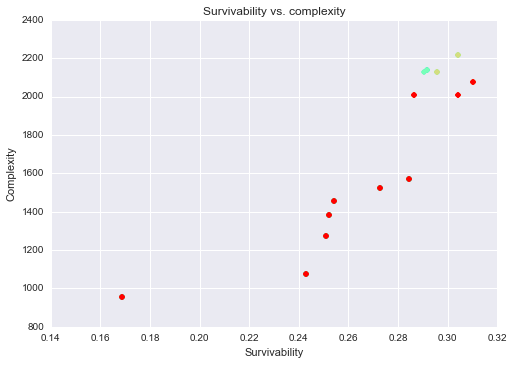

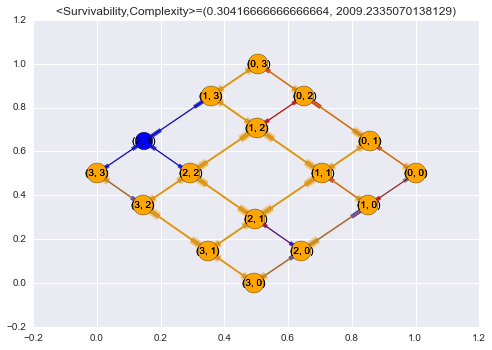

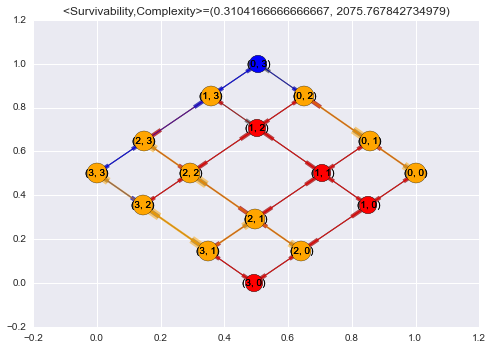

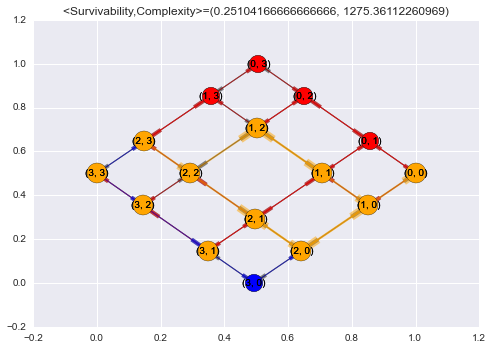

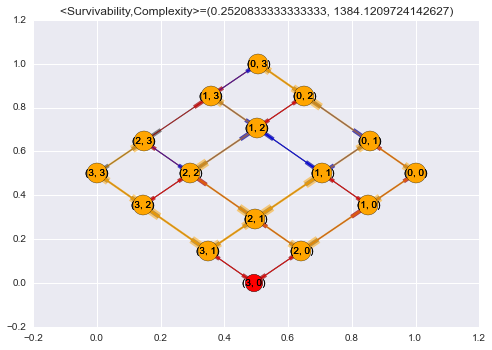

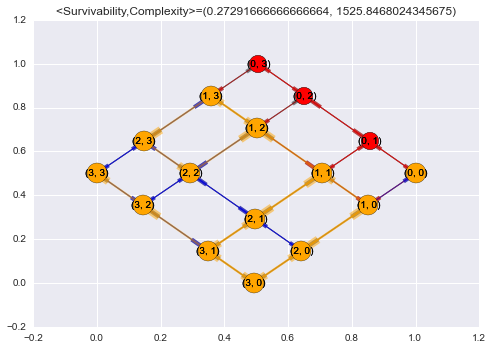

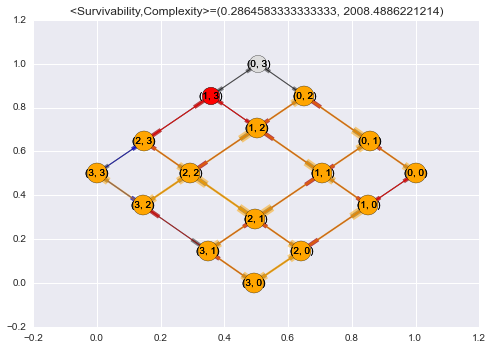

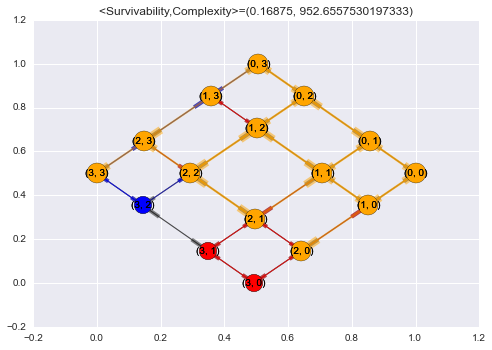

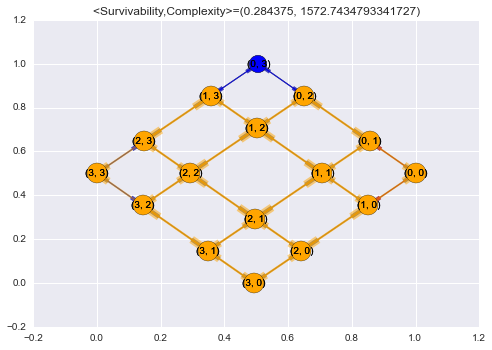

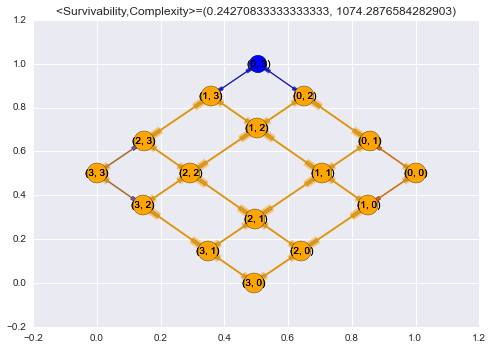

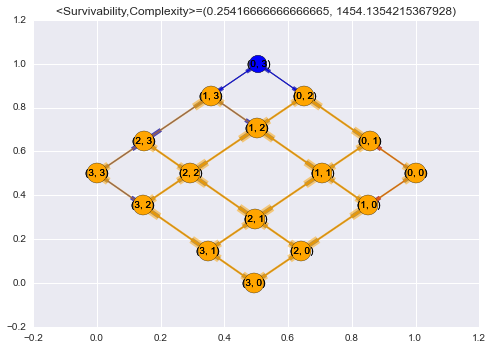

In [18]:
'''
Run Example
'''

#space=Space()

space=Space(size=[4,4],num_ants=10,num_colonies=10,
            source=[[(0,0)],[(3,3)]],source_magnitude=[[20],[10]],
            sink=[[(3,3),(1,3)],[(0,0),(2,0)]],sink_magnitude=[[10,10],[5,5]], sink_threshold=[[.5,1.0],[1.0,1.0]],
            links=[(1,0,(3,3))],capacities=[[5,10],[5]],edge_capacity=20,percent_removals=.50,
            dissipation=0.5,initial_pheromone=.10,initial_termination=1.0,
            alpha=1.0,beta=1.0)

#space=Space(size=[4,4,4],num_ants=10,num_colonies=10,
            #source=[[(0,2,0)],[(3,3,0)]],source_magnitude=[[20],[10]],
            #sink=[[(3,3,0),(1,3,3)],[(0,0,1),(2,0,3)]],sink_magnitude=[[10,10],[5,5]], sink_threshold=[[.5,1.0],[1.0,1.0]],
            #links=[(1,0,(3,3,0))],capacities=[[5,10],[5]],edge_capacity=20,percent_removals=.50,
            #dissipation=0.2,initial_pheromone=1.0,initial_termination=1.0,
            #alpha=1.0,beta=0.0)

#space=Space(size=[5,5,3],num_ants=10,num_colonies=10,source=[[(0,3,0),(0,1,0)],[20,20]],
            #sink=[[(3,2,2),(1,4,2),(4,4,2),(3,4,0)],[10,10,15,5]],
            #initial_pheromone=1,beta=2.0,capacities=[5,10,15,20])
converged=0
i=1
pareto_history=[]
criteria=0
while not converged:
    space.step()
    print 'Pareto front of generation',i,':',space.paretoPoints #'\r',
    pareto_history.append(space.paretoPoints)
    if i>5 and pareto_history[-1]==pareto_history[-2]:
        criteria+=1
    else:
        criteria=0
    #print criteria
    if criteria>10:
        converged=1
    
    #print '\r',i,',',
    i+=1
    if i>55:
        converged=1
        print '\n'
        

print('Ant Path')

    

# Remove the nonpath from path nodes
#nonpath_nodes = [node for node in space.g.nodes() if node not in space.ant_graphs[space.opt_ant[0]][0]]

# Now we can visualize the infected node's position
#visualize_system(space.ant_graphs[space.opt_ant[-1]][0],space.g,space.paretoPoints[-1])

#Plot Solutions
#front_x=[i[0] for i in space.paretoPoints]
#front_y=[i[1] for i in space.paretoPoints]
#dominated_x=[i[0] for i in space.dominatedPoints]
#dominated_y=[i[1] for i in space.dominatedPoints]
f = plt.figure()
#plt.scatter(dominated_x,dominated_y,alpha=0.5)
#plt.scatter(front_x,front_y,color='red',alpha=1)

colors = cm.rainbow(numpy.linspace(0, 1, len(pareto_history)))
#print colors
for gen, c in zip(pareto_history, colors):
    x=[i[0] for i in gen]
    y=[i[1] for i in gen]
    #print c
    plt.scatter(x, y, color=c)

plt.xlabel("Survivability")
plt.ylabel("Complexity")
plt.title("Survivability vs. complexity")

for i in xrange(len(space.opt_ant)):
    score=space.paretoPoints[i]
    visualize_system_single(space.ant_graphs[space.opt_ant[i]][0],space.g,score)


[[  5.00000000e-01   0.00000000e+00   1.00000000e+00   1.00000000e+00]
 [  3.98039216e-01   1.59475791e-01   9.96795325e-01   1.00000000e+00]
 [  2.96078431e-01   3.14869589e-01   9.87201840e-01   1.00000000e+00]
 [  1.86274510e-01   4.73093557e-01   9.69796936e-01   1.00000000e+00]
 [  8.43137255e-02   6.07538946e-01   9.47177357e-01   1.00000000e+00]
 [  2.54901961e-02   7.34844967e-01   9.16033601e-01   1.00000000e+00]
 [  1.27450980e-01   8.33602385e-01   8.81012194e-01   1.00000000e+00]
 [  2.37254902e-01   9.16033601e-01   8.36989108e-01   1.00000000e+00]
 [  3.39215686e-01   9.68276041e-01   7.90532412e-01   1.00000000e+00]
 [  4.49019608e-01   9.96795325e-01   7.34844967e-01   1.00000000e+00]
 [  5.50980392e-01   9.96795325e-01   6.78235117e-01   1.00000000e+00]
 [  6.60784314e-01   9.68276041e-01   6.12420203e-01   1.00000000e+00]
 [  7.62745098e-01   9.16033601e-01   5.47219547e-01   1.00000000e+00]
 [  8.72549020e-01   8.33602385e-01   4.73093557e-01   1.00000000e+00]
 [  9.

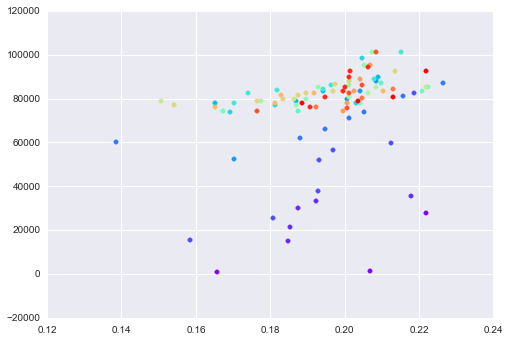

In [103]:
import matplotlib.cm as cm
colors = cm.rainbow(numpy.linspace(0, 1, len(pareto_history)))
print colors
for gen, c in zip(pareto_history, colors):
    x=[i[0] for i in gen]
    y=[i[1] for i in gen]
    print c
    plt.scatter(x, y, color=c)

In [4]:
def visualize_system_single(system,area,score):
    #system=system_list[index]
    
    # Remove the nonpath from path nodes
    path_nodes=[[],[]]
    for i in xrange(2):
        path_nodes[i] = [node for node in area.nodes() if node in system[i]]
    
    nonpath_nodes = [node for node in area.nodes() if node not in system[0] or node not in system[1]]
    
    # Removed shared nodes
    shared_nodes=[]
    for n in area.nodes():
        if n in path_nodes[0] and n in path_nodes[1]:
            shared_nodes.append(n)
            path_nodes[0].remove(n)
            path_nodes[1].remove(n)
    
    # Remove edges
    path_edges=[[],[]]
    for i in xrange(2):
        path_edges[i]=system[i].edges()
        
    # Remove shared edges
    shared_edges=[]
    for e in area.edges():
        if e in path_edges[0] and e in path_edges[1]:
            shared_edges.append(e)
            path_edges[0].remove(e)
            path_edges[1].remove(e)
    
    
    area_layout=nx.spectral_layout(area)
    # Now we can visualize the infected node's position
    f = plt.figure()

    nx.draw_networkx_nodes(area, area_layout,
                           nodelist=nonpath_nodes,
                           node_color='#dddddd')
    
    nx.draw_networkx_nodes(system[0], area_layout, 
                           nodelist=path_nodes[0],
                           node_color='red')
    
    nx.draw_networkx_nodes(system[1], area_layout, 
                           nodelist=path_nodes[1],
                           node_color='blue')
    
    nx.draw_networkx_nodes(system[0], area_layout, 
                           nodelist=shared_nodes,
                           node_size=400,
                           node_color='orange')

    nx.draw_networkx_edges(area, area_layout, 
                           width=1.0, 
                           alpha=0.5,
                           edge_color='#111111')

    nx.draw_networkx_edges(system[0], area_layout,
                          edgelist=path_edges[0],
                          width=1.0, 
                          alpha=0.5,
                          edge_color='red')
    
    nx.draw_networkx_edges(system[1], area_layout,
                          edgelist=path_edges[1],
                          width=1.0, 
                          alpha=0.5,
                          edge_color='blue')
    
    nx.draw_networkx_edges(system[0], area_layout,
                          edgelist=shared_edges,
                          width=2.0, 
                          alpha=0.5,
                          edge_color='orange')

    _ = nx.draw_networkx_labels(area, area_layout,
                            dict(zip(area.nodes(), area.nodes())),
                            font_size=10)
    _ = nx.draw_networkx_labels(area, area_layout,
                            dict(zip(area.nodes(), area.nodes())),
                            font_size=10)
    
    plt.title('<Survivability,Complexity>={}'.format(score))

In [25]:
def visualize_system(system,area,score):
    #system=system_list[index]
    
    # Remove the nonpath from path nodes
    nonpath_nodes=[[],[]]
    for i in xrange(2):
        nonpath_nodes[i] = [node for node in area.nodes() if node not in system[i]]

    area_layout=nx.spectral_layout(area)
    # Now we can visualize the infected node's position
    f = plt.figure()
    f.add_subplot(221)
    nx.draw_networkx_nodes(system[0], area_layout,
                           node_color='red',edge_color='red')

    nx.draw_networkx_nodes(area, area_layout,
                           nodelist=nonpath_nodes[0],
                           node_color='#dddddd')

    nx.draw_networkx_edges(area, area_layout, 
                           width=1.0, 
                           alpha=0.5,
                           edge_color='#111111')

    nx.draw_networkx_edges(system[0], area_layout,
                          edgelist=system[0].edges(),
                          width=1.0, 
                          alpha=0.5,
                          edge_color='red')

    _ = nx.draw_networkx_labels(area, area_layout,
                            dict(zip(area.nodes(), area.nodes())),
                            font_size=10)
    _ = nx.draw_networkx_labels(area, area_layout,
                            dict(zip(area.nodes(), area.nodes())),
                            font_size=10)
    f.add_subplot(222)
    nx.draw_networkx_nodes(system[1], area_layout,
                           node_color='red',edge_color='red')

    nx.draw_networkx_nodes(area, area_layout,
                           nodelist=nonpath_nodes[1],
                           node_color='#dddddd')

    nx.draw_networkx_edges(area, area_layout, 
                           width=1.0, 
                           alpha=0.5,
                           edge_color='#111111')

    nx.draw_networkx_edges(system[1], area_layout,
                          edgelist=system[1].edges(),
                          width=1.0, 
                          alpha=0.5,
                          edge_color='blue')

    _ = nx.draw_networkx_labels(area, area_layout,
                            dict(zip(area.nodes(), area.nodes())),
                            font_size=10)
    _ = nx.draw_networkx_labels(area, area_layout,
                            dict(zip(area.nodes(), area.nodes())),
                            font_size=10)
    
    f.suptitle('<Survivability,Complexity>={}'.format(score))

In [12]:
def split_lists(input_list):
    half = len(input_list)/2
    return input_list[:half], input_list[half:]

l=[1,2,3,4]
s=[[],[]]
s[0],s[1]=split_lists(l)
print s[0]

[1, 2]


In [55]:
l=[0,0,1]
print [[l]*2]*2
print list([[l]*2]*2)


[[[0, 0, 1], [0, 0, 1]], [[0, 0, 1], [0, 0, 1]]]
[[[0, 0, 1], [0, 0, 1]], [[0, 0, 1], [0, 0, 1]]]


In [40]:
ph=[1]*2*2
ph.extend([2]*1*2)
print ph
print ph[:4]

[1, 1, 1, 1, 2, 2]
[1, 1, 1, 1]


In [46]:
ph[4:]

[2, 2]

In [99]:
print space.opt_ant

[4, 7, 32, 34, 39, 45, 83, 91, 99]


In [117]:
l=[1,2,3,5,78]
keep=[1,3]
rem=list(set(l)-set(keep))
print rem
nl=[]
for i in range(len(l)):
    print i
    if i in keep:
        nl.append(l[i])
        
print nl
l=nl
print l

[2, 5, 78]
0
1
2
3
4
[2, 5]
[2, 5]


In [23]:
print nx.get_edge_attributes(space.g,'edge_pheromone')


{((2, 1), (3, 1)): [3.4774769368134075, 3.4774769368134075, 1.6454829567500895, 1.6454829567500895], ((1, 0), (2, 0)): [0.08705226742460691, 0.08705226742460691, 0.0011529215046068484, 0.0011529215046068484], ((0, 3), (1, 3)): [0.328832921504607, 0.328832921504607, 0.04168531815094134, 0.04168531815094134], ((0, 2), (1, 2)): [0.019167320014088853, 0.019167320014088853, 0.04168531815094134, 0.04168531815094134], ((1, 1), (2, 1)): [4.575294449627931, 4.575294449627931, 2.8035003008069417, 2.8035003008069417], ((1, 1), (1, 2)): [0.36970796929963906, 0.36970796929963906, 0.023670919641459346, 0.023670919641459346], ((2, 0), (2, 1)): [1.1813004191756726, 1.1813004191756726, 0.023670919641459346, 0.023670919641459346], ((2, 0), (1, 0)): [4.448182988973305, 4.448182988973305, 4.943506846274265, 4.943506846274265], ((0, 1), (0, 0)): [4.2350933577228895, 4.2350933577228895, 0.3513509196414594, 0.3513509196414594], ((2, 1), (2, 2)): [3.9352944496279307, 3.9352944496279307, 0.04168531815094134, 0

In [6]:
print nx.get_node_attributes(space.g,'termination_pheromone')

{(1, 2): [0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383], (0, 1): [0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383], (3, 2): [0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383], (1, 3): [0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383], (3, 3): [0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383], (3, 0): [0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383], (3, 1): [0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383], (2, 1): [0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383], (1, 1): [0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 0.0, 0.00737869762948383, 

In [68]:
gs=space.ant_graphs[space.opt_ant[0]][0]
print gs[0].number_of_nodes()
print gs[0].number_of_edges()
print gs[1].number_of_nodes()
print gs[1].number_of_edges()
print not gs[0].has_node((4,4))
print (4,4) not in gs[0]

7
6
7
6
True
True


In [11]:
print nx.get_node_attributes(space.g,'branch_pheromone')

{(1, 2): [1.3812499999999999, 1.713645833333333, 1.3745833333333333, 9.36208333333333, 1.5, 1.802857142857143, 1.5861904761904762, 10.07984126984127, 1.16875, 0.01, 0.41000000000000003, 12.752708333333333, 1.25, 0.01, 0.3766666666666667, 13.726666666666656], (0, 1): [2.8161458333333336, 1.5573958333333333, 9.974062499999995, 3.0944444444444446, 1.8306349206349206, 10.644920634920629, 1.6749999999999998, 0.3959375, 12.091770833333333, 1.7277777777777779, 0.3766666666666667, 12.998888888888878], (3, 2): [5.398958333333331, 1.8626041666666666, 5.830312500000002, 6.238095238095241, 2.0100000000000002, 5.260793650793653, 1.2, 0.6219791666666666, 12.911562499999999, 1.3333333333333333, 0.8433333333333333, 13.843333333333321], (1, 3): [2.176041666666667, 1.1178125, 11.439687499999998, 2.2023809523809526, 1.1877777777777778, 12.62984126984126, 1.9286458333333332, 1.0105208333333333, 11.223541666666666, 1.8111111111111113, 0.9639682539682539, 12.328253968253959], (3, 3): [1.0, 13.72354166666666